## 1. Upload the data nd libraries

### 1.1 Imports necessary libraries

In [1]:
# Python
import pickle

# Third party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.impute import KNNImputer

# Local imports
from _csv_utils import data_timeplace, DataPathCleaningManager

### 1.2 Import the data

In [2]:

data_path_manager = DataPathCleaningManager(data_timeplace)
df = data_path_manager._load_cleaned_df(domain="combined")

In [3]:
# choose relevant columns
df.columns.tolist()

[('listing', 'link'),
 ('listing', 'title'),
 ('listing', 'summary_description'),
 ('listing', 'remote_service'),
 ('pricing', 'price'),
 ('pricing', 'rent'),
 ('pricing', 'total_rent'),
 ('pricing', 'total_rent_sqm'),
 ('pricing', 'deposit'),
 ('pricing', 'deposit_ratio'),
 ('location', 'complete_address'),
 ('location', 'street'),
 ('location', 'city'),
 ('location', 'voivodeship'),
 ('size', 'square_meters'),
 ('size', 'number_of_rooms'),
 ('size', 'floor'),
 ('size', 'attic'),
 ('size', 'building_floors'),
 ('legal_and_availability', 'available_from'),
 ('legal_and_availability', 'completion'),
 ('legal_and_availability', 'ownership'),
 ('legal_and_availability', 'rent_to_students'),
 ('type_and_year', 'building_type'),
 ('type_and_year', 'build_year'),
 ('amenities', 'elevator'),
 ('amenities', 'parking_space'),
 ('equipment', 'no_information'),
 ('equipment', 'stove'),
 ('equipment', 'fridge'),
 ('equipment', 'furniture'),
 ('equipment', 'oven'),
 ('equipment', 'washing_machine')

### 1.3 Remove outliers
In our scenario, it's not necessary to have a model that perfectly aligns with every specific local case. Instead, we need a model that is well-suited for the average situation.

In [4]:
df_outliers_filtered = df[df[('pricing', 'total_rent')] < 9000]
df_outliers_filtered = df_outliers_filtered[df_outliers_filtered[('type_and_year', 'building_type')] != 'detached_house']

### 1.4 Select relevant data

In [5]:
# relevant but mutlicollinearity:
# level 1 - very high
# level 2 - high

df_model = pd.DataFrame()

columns_to_select = [
    ('pricing', 'total_rent'),
    ('location', 'city'),
    ('size', 'square_meters'),
    # ('size', 'number_of_rooms'), # level 1
    ('type_and_year', 'building_type'),
    ('type_and_year', 'build_year'),
    ('amenities', 'elevator'),
    ('amenities', 'parking_space'),
    # ('equipment', 'furniture'), # level 1
    # ('equipment', 'stove'), # level 1
    ('equipment', 'oven'),
    ('equipment', 'washing_machine'),
    # ('equipment', 'TV'),
    ('equipment', 'dishwasher'),
    # ('media_types', 'internet'), # level 2
    # ('media_types', 'cable_TV'), # level 2
    ('heating', 'district'),
    ('security', 'monitoring_or_security'),
    # ('security', 'anti_burglary_doors_or_windows'), # level 2
    # ('security', 'enclosed_area'), # level 2
    ('windows', 'aluminum'),
    ('size', 'floor'),
    # ('size', 'building_floors'), # level 1
    ('additional_information', 'air_conditioning'),
    ('additional_information', 'utility_room'),
]

extracted_columns = df_outliers_filtered.loc[:, columns_to_select]


extracted_columns.columns = extracted_columns.columns.droplevel(0)

extracted_columns = extracted_columns.rename(columns={
    'district': 'heating_district',
    'aluminum': 'windows_aluminum',
})
df_model[extracted_columns.columns] = extracted_columns

In [6]:
df_model.dtypes

total_rent                float64
city                       string
square_meters               Int64
building_type              string
build_year                float64
elevator                     bool
parking_space                bool
oven                         bool
washing_machine              bool
dishwasher                   bool
heating_district             bool
monitoring_or_security       bool
windows_aluminum             bool
floor                       Int64
air_conditioning             bool
utility_room                 bool
dtype: object

## 2. Get dummy data

Transforms categorical variables into numerical form by creating binary indicator variables for each category, resulting in a new DataFrame called 'df_dum'

In [7]:
df_dum = pd.get_dummies(df_model)

In [8]:
df_dum.columns

Index(['total_rent', 'square_meters', 'build_year', 'elevator',
       'parking_space', 'oven', 'washing_machine', 'dishwasher',
       'heating_district', 'monitoring_or_security', 'windows_aluminum',
       'floor', 'air_conditioning', 'utility_room', 'city_Bytom',
       'city_Chorzów', 'city_Dąbrowa Górnicza', 'city_Jaworzno',
       'city_Katowice', 'city_Mysłowice', 'city_Piekary Śląskie',
       'city_Ruda Śląska', 'city_Siemianowice Śląskie', 'city_Sosnowiec',
       'city_Zawada', 'city_będziński', 'city_częstochowski',
       'city_tarnogórski', 'city_zawierciański', 'city_Świętochłowice',
       'building_type_apartment_building', 'building_type_block_of_flats',
       'building_type_historic_apartment_building',
       'building_type_terraced_house'],
      dtype='object')

## 3. Train the split
Splits the data into two separate datasets, one for training the model and the other for testing its performance, using the train_test_split function from scikit-learn.

In [9]:
# Splitting the dataset into features (X) and target variable (Y), where 'total_rent' is the target.
X = df_dum.drop('total_rent', axis =1)
Y = df_dum['total_rent']

# Converting boolean columns to integers for model compatibility. Models typically require numerical input.
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# Replacing infinite values with NaN in the features to avoid errors during model training.
X = X.replace([np.inf, -np.inf], np.nan)

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply the imputer to the feature set. Note: It's important to do this before the train-test split.
X_imputed = knn_imputer.fit_transform(X)
X_imputed = X_imputed.astype(float)

# Now, handle the target variable
Y = Y.replace([np.inf, -np.inf], np.nan)
Y = Y.fillna(0)

# Splitting the dataset into training and testing sets for model validation.
X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y.values, test_size=0.2, random_state=42)

In [10]:
my_xnames = pd.Index(['total_rent'] + X.columns.tolist())

## 4. Multiple Linear Regression
This section implements a Multiple Linear Regression model using the Ordinary Least Squares (OLS) method from the statsmodels library. In this approach, the model aims to establish a linear relationship between multiple independent variables (features) and a single dependent variable (target). The OLS method is employed to determine the line of best fit, which is achieved by minimizing the sum of the squares of the residuals - the differences between the observed values and the values predicted by the model. This process allows for an efficient and effective way to understand how each independent variable contributes to the dependent variable, facilitating predictions and insights into the underlying data relationships.

In [11]:
# Y_train = Y_train.astype(float)

# Adding a constant to the feature set and constructing the OLS model
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train_sm)

# You can name the variables in your model for better readability
# Assuming 'my_xnames' is defined and includes the names of your features
model.data.xnames = ['Intercept'] + X.columns.tolist()

In [12]:
results = model.fit().summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     40.32
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          3.22e-134
Time:                        14:16:56   Log-Likelihood:                -6068.7
No. Observations:                 772   AIC:                         1.220e+04
Df Residuals:                     741   BIC:                         1.234e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                 -1680.6112   1887.992     -0.890      0.374   -5387.061    2025.839
square_meters                                25.0688      1.183     21.182      0.000      22.745      27.392
build_year                                    1.4597      1.248      1.170      0.243      -0.990       3.910
elevator                                    195.6434     65.160      3.003      0.003      67.724     323.563
parking_space                               101.0080     59.544      1.696      0.090     -15.887     217.903
oven                                         57.4315     76.123      0.754      0.451     -92.012     206.875
washing_machine                              16.5100     74.330      0.222      0.824    -129.413     162.433
dishwasher                                  199.3280     67.697      2.944      0.003      66.428     332.228
heating_district                            166.9138     58.636      2.847      0.005      51.801     282.027
monitoring_or_security                      110.7220     68.999      1.605      0.109     -24.735     246.179
windows_aluminum                            917.6176    650.853      1.410      0.159    -360.119    2195.354
floor                                       -16.8925     10.550     -1.601      0.110     -37.604       3.819
air_conditioning                            502.8500     89.436      5.622      0.000     327.273     678.427
utility_room                               -140.6069     74.375     -1.891      0.059    -286.618       5.404
city_Bytom                                 -202.4935    156.836     -1.291      0.197    -510.389     105.402
city_Chorzów                                 48.1164    179.289      0.268      0.788    -303.859     400.092
city_Dąbrowa Górnicza                       205.7942    173.999      1.183      0.237    -135.796     547.385
city_Jaworzno                              -206.6518    196.307     -1.053      0.293    -592.036     178.732
city_Katowice                               362.6518    151.781      2.389      0.017      64.681     660.623
city_Mysłowice                                3.7114    215.666      0.017      0.986    -419.678     427.100
city_Piekary Śląskie                       -352.1634    224.661     -1.568      0.117    -793.211      88.885
city_Ruda Śląska                           -139.1702    304.757     -0.457      0.648    -737.460     459.120
city_Siemianowice Śląskie                    -5.3780    234.014     -0.023      0.982    -464.788     454.031
city_Sosnowiec                               52.4903    158.749      0.331      0.741    -259.161     364.141
city_Zawada                                 332.1310    611.933      0.543      0.587    -869.197    1533.459
cit

C:\Users\karol\AppData\Local\Temp\ipykernel_72168\3920633229.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_model.corr()


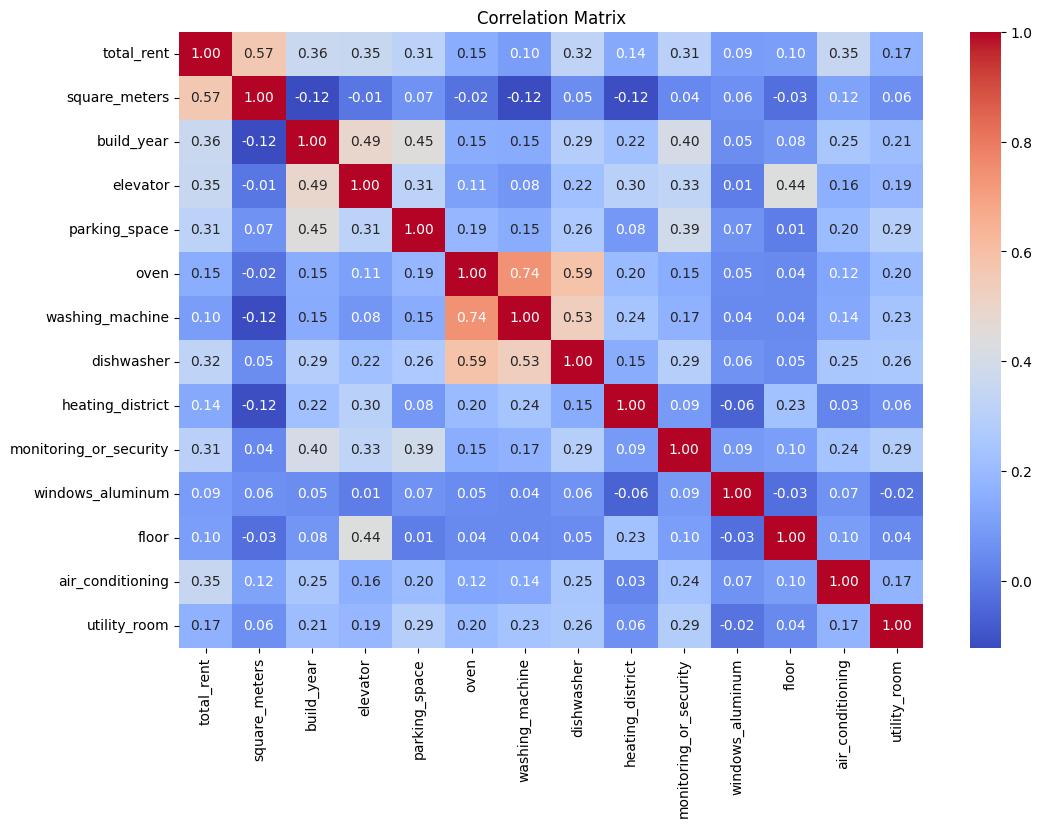

In [13]:
corr_matrix = df_model.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [14]:
def get_t_results(results, t_cap):
    table_index = 1

    table_data = results.tables[table_index].data

    filtered_data = [row for row in table_data if float(row[-2].replace("[", "")) >= t_cap]

    sorted_data = sorted(filtered_data, key=lambda x: float(x[-2].replace("[", "")), reverse=True)

    filtered_table = SimpleTable(sorted_data, title=results.tables[table_index].title)

    print(f"passed_t_variables: {len(filtered_data)}")
    print(f"variables: {len(table_data)}")
    print(f"percentage: {round((len(filtered_data) / len(table_data)) * 100, 2)}")
    return filtered_table

get_t_results(results, 0.05)

passed_t_variables: 6
variables: 35
percentage: 17.14


air_conditioning,502.8500,89.436,5.622,0.000,327.273,678.427
elevator,195.6434,65.160,3.003,0.003,67.724,323.563
dishwasher,199.3280,67.697,2.944,0.003,66.428,332.228
city_Katowice,362.6518,151.781,2.389,0.017,64.681,660.623
heating_district,166.9138,58.636,2.847,0.005,51.801,282.027
square_meters,25.0688,1.183,21.182,0.000,22.745,27.392


In [15]:
lm = LinearRegression()
lm.fit(X_train, Y_train)

np.mean(cross_val_score(lm,X_train,Y_train, scoring = 'neg_mean_absolute_error', cv=10))

-460.09936143536186

## 5. Lasso regression
Performs Lasso regression with different alpha values and calculates the mean absolute error for each alpha value.

In [16]:
lm_l = Lasso(alpha=.99)
lm_l.fit(X_train,Y_train)
avg_score = np.mean(cross_val_score(lm_l,X_train,Y_train, scoring = 'neg_mean_absolute_error', cv= 10))
avg_score

-458.8556107934007

c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.269e+07, tolerance: 7.040e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.650e+06, tolerance: 6.903e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

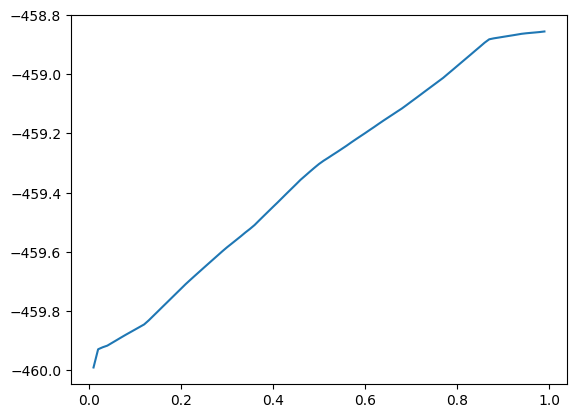

Best alpha: 0.99


In [17]:
alpha = []
error = []

# Loop to populate alpha and error lists
for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml, X_train, Y_train, scoring='neg_mean_absolute_error', cv=10)))

# Plotting
plt.plot(alpha, error)
plt.show()

# Finding the best alpha
best_alpha_index = np.argmax(error)  # Get the index of the best error
best_alpha = alpha[best_alpha_index]  # Use index to find the corresponding alpha
print(f"Best alpha: {best_alpha}")


## 6. Random Forest
Creates a random forest regressor (rf) and calculates the mean absolute error using cross-validation.

In [18]:
rf = RandomForestRegressor()

np.mean(cross_val_score(rf,X_train,Y_train,scoring = 'neg_mean_absolute_error', cv= 15))

-443.816968050468

## 7. Tune Models GridsearchCV
Performs hyperparameter tuning for the random forest model using GridSearchCV, trying different combinations of n_estimators, criterion, and max_features.

In [19]:
parameters = {'n_estimators':range(10,300,10), 'criterion':('friedman_mse','absolute_error', 'poisson', 'squared_error'), 'max_features':('auto','sqrt','log2')}

# gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=10)
# gs.fit(X_train,Y_train)

# gs.best_score_
# gs.best_estimator_

In [20]:
# test ensembles 
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
# tpred_rf = gs.best_estimator_.predict(X_test)

print(f"tpred_lm: {mean_absolute_error(Y_test,tpred_lm)}")
print(f"tpred_lml: {mean_absolute_error(Y_test,tpred_lml)}")
# print(f"tpred_rf: {mean_absolute_error(Y_test,tpred_rf)}")

# print(f"tpred_lm + tpred_rf: {mean_absolute_error(Y_test,(tpred_lm+tpred_rf)/2)}")
print(f"tpred_lm + tpred_lml: {mean_absolute_error(Y_test,(tpred_lm+tpred_lml)/2)}")
# print(f"tpred_rf + tpred_lml: {mean_absolute_error(Y_test,(tpred_lml+tpred_rf)/2)}")

tpred_lm: 460.74180087632374
tpred_lml: 460.4281368559
tpred_lm + tpred_lml: 458.75296391731104


## 8. Other models

### 8.1 Testing other models

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Initialize the new models
gbm = GradientBoostingRegressor()
svm = SVR()
dt = DecisionTreeRegressor()

# Fit the models to the training data
gbm.fit(X_train, Y_train)
svm.fit(X_train, Y_train)
dt.fit(X_train, Y_train)

# Make predictions
tpred_gbm = gbm.predict(X_test)
tpred_svm = svm.predict(X_test)
tpred_dt = dt.predict(X_test)

# Print MAE for each model
print(f"tpred_gbm: {mean_absolute_error(Y_test, tpred_gbm)}")
print(f"tpred_svm: {mean_absolute_error(Y_test, tpred_svm)}")
print(f"tpred_dt: {mean_absolute_error(Y_test, tpred_dt)}")

# Ensemble predictions with new models
print(f"tpred_lm + tpred_gbm: {mean_absolute_error(Y_test, (tpred_lm+tpred_gbm)/2)}")
# print(f"tpred_rf + tpred_svm: {mean_absolute_error(Y_test, (tpred_rf+tpred_svm)/2)}")
print(f"tpred_lml + tpred_dt: {mean_absolute_error(Y_test, (tpred_lml+tpred_dt)/2)}")

tpred_gbm: 425.9044685231481
tpred_svm: 833.015358670341
tpred_dt: 624.0
tpred_lm + tpred_gbm: 433.7319574007022
tpred_lml + tpred_dt: 472.78272571231975


### 8.2 Fine tuning selected model

#### 8.2.1 Grid Search Cross-Validation

In [29]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    # Add other parameters here
}

grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, Y_train)
gsc_best_params = grid_search.best_params_

#### 8.2.2 Randomized Search Cross-Validation

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {
    'n_estimators': sp_randint(100, 500),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': sp_randint(3, 10),
    # 'min_samples_split': sp_randint(2, 10),
    # 'min_samples_leaf': sp_randint(1, 10),
    # 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    # 'max_features': ['auto', 'sqrt', 'log2', None],
    # 'loss': ['absolute_error', 'quantile', 'squared_error', 'huber'],
    # 'criterion': ['friedman_mse', 'squared_error']
}

n_iter_search = 20
random_search = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_absolute_error')
random_search.fit(X_train, Y_train)
rsc_best_params = random_search.best_params_


#### 8.2.3 Evaluating the params

In [69]:
# Using the best parameters from Grid Search to create and fit the model
gbm_grid = GradientBoostingRegressor(**gsc_best_params)
gbm_grid.fit(X_train, Y_train)
tpred_gbm_grid = gbm_grid.predict(X_test)
mae_gbm_grid = mean_absolute_error(Y_test, tpred_gbm_grid)
print(f"MAE for Grid Search model: {mae_gbm_grid}")

# Using the best parameters from Randomized Search to create and fit the model
gbm_random = GradientBoostingRegressor(**rsc_best_params)
gbm_random.fit(X_train, Y_train)
tpred_gbm_random = gbm_random.predict(X_test)
mae_gbm_random = mean_absolute_error(Y_test, tpred_gbm_random)
print(f"MAE for Randomized Search model: {mae_gbm_random}")

MAE for Grid Search model: 425.1355278675289
MAE for Randomized Search model: 441.41732884173666


## 9. Save model and validate it

In [64]:
# Assuming 'gbm' is your trained Gradient Boosting Machine model
pickl = {'model': gbm_random}

# Saving the model to a file
pickle.dump(pickl, open('gbm_model_file.p', 'wb'))

In [65]:
file_name = "gbm_model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

In [66]:
model.predict(X_test[1].reshape(1, -1))

array([1843.81877985])

In [67]:
list(X_test[1])

[48.0,
 1977.6,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 10.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0]